## Estadística Aplicada

Sesion 15- 20 octubre

Cecilia Sarahí Gutiérrez Padilla 1953437 gpo 43

In [1]:
## básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [34]:
## especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

## ARIMA
from statsmodels.tsa.arima.model import ARIMA

## diagnostico del orden ARIMA
import pmdarima as pm

In [7]:
## datos
df_amazon= pd.read_excel('amazon.xlsx')

In [8]:
df_amazon.head()

,fecha,amazon
0,2015-01-02,24.573591
1,2015-01-05,23.830631
2,2015-01-06,24.070295
3,2015-01-07,24.453760
4,2015-01-08,24.301968


In [10]:
df_amazon.tail()

,fecha,amazon
1250,2019-12-23,52.589653
1251,2019-12-24,52.599163
1252,2019-12-26,52.561153
1253,2019-12-27,52.865196
1254,2019-12-30,51.478008


In [11]:
ultima_obs=df_amazon.loc[1254]
df_amazon=df_amazon.loc[:1253]

In [12]:
ultima_obs

fecha     2019-12-30 00:00:00
amazon              51.478008
Name: 1254, dtype: object

In [13]:
df_amazon.tail()

,fecha,amazon
1249,2019-12-20,54.128864
1250,2019-12-23,52.589653
1251,2019-12-24,52.599163
1252,2019-12-26,52.561153
1253,2019-12-27,52.865196


In [14]:
## variable tiempo
## variable tiempo debe ser el index
## frecuencia asignada
df_amazon.dtypes

fecha     datetime64[ns]
amazon           float64
dtype: object

In [15]:
## convertir en index
df_amazon=df_amazon.set_index('fecha')

In [16]:
## asignar frecuencia
## días hábiles -- bussiness days
df_amazon= df_amazon.asfreq('B')

In [17]:
df_amazon.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27'],
              dtype='datetime64[ns]', name='fecha', length=1301, freq='B')

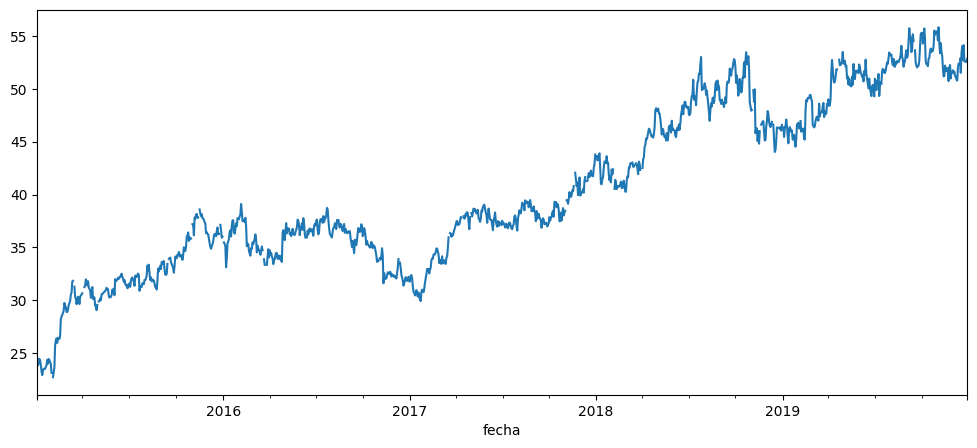

In [18]:
## graficar 
df_amazon['amazon'].plot(figsize=(12,5))
plt.show()

In [19]:
df_amazon.isnull().sum()

amazon    47
dtype: int64

In [20]:
## rellenar los missing values
df_amazon['amazon']= df_amazon['amazon'].fillna(method='pad')

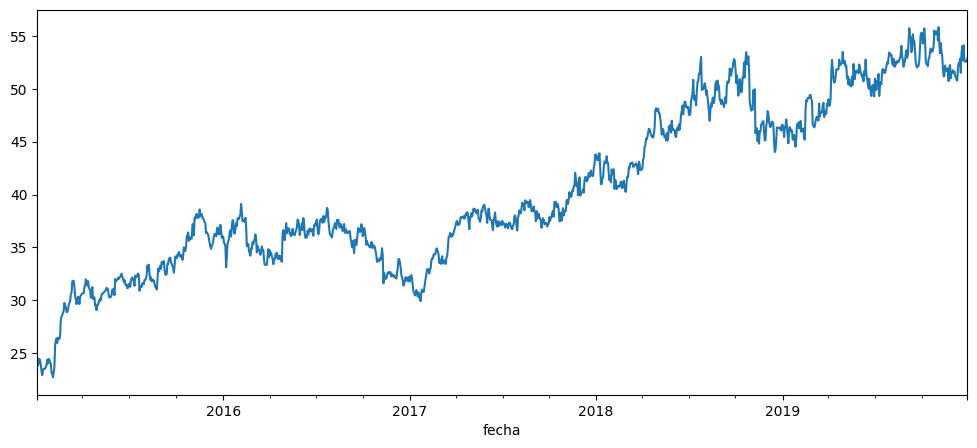

In [21]:
## graficar 
df_amazon['amazon'].plot(figsize=(12,5))
plt.show()

los precios de la acción de amazon se comportan como una caminata aleatoria y por tanto deberia ser un proceso no estacionario 

In [22]:
## Prueba de Dickey-Fuller Aumentada
## Ho: No estacionaria
## Ha: Estacionaria
prueba_ADF= adfuller(df_amazon['amazon'])
pvalue= prueba_ADF[1]
pvalue.round(2)

0.52

No se rechaza Ho, significa que el precio de amazon es una seria **no estacionaria**

In [23]:
## Aplicar 1ras diferencias al precio de la acción de amazon
df_amazon['amazon_diff']= df_amazon['amazon'].diff()


In [24]:
df_amazon.head()

,amazon,amazon_diff
fecha,,
2015-01-02,24.573591,NaN
2015-01-05,23.830631,-0.742960
2015-01-06,24.070295,0.239664
2015-01-07,24.453760,0.383465
2015-01-08,24.301968,-0.151793


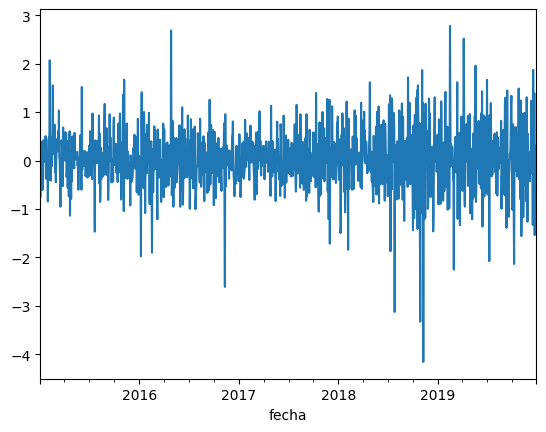

In [26]:
df_amazon['amazon_diff'].plot()
plt.show()

In [27]:
## prueba dickey-fuller aumentada
prueba_ADF=adfuller(df_amazon['amazon_diff'].dropna())
pvalue1= prueba_ADF[1]
pvalue1.round(2)

0.0

Rechazamos Ho, las primeras diferencias de amazon son un proceso estacionario
* Amazon integrado I(1)
* Primeras diferencias amazon son integradas I(0)

Ya sabemos que las 1ras diferencias son un proceso estacionario ¿Qué tipo de proceso estacionario son?\
* Ruido blanco
* AR(p)
* MA(q)
* ARMA (p,q)

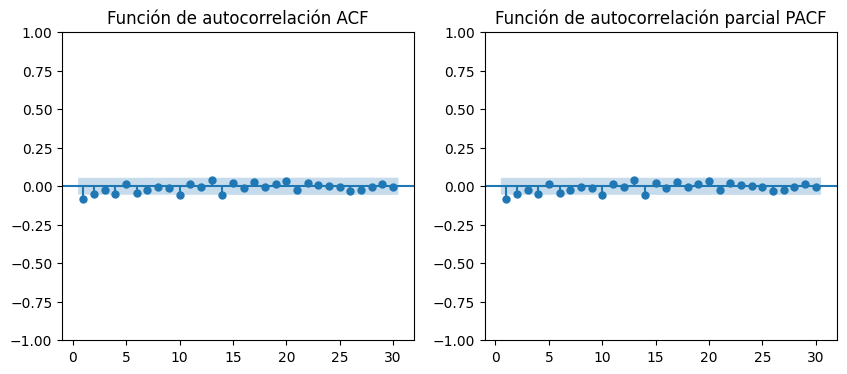

In [33]:
## gráficas de autocorrelación
ig, ax= plt.subplots(1,2, figsize= (10,4))
## 1er subgráfica
plot_acf(df_amazon['amazon_diff'].dropna(), zero= False, lags=30, ax=ax[0], title='Función de autocorrelación ACF')
## 2da subgráfica
plot_acf(df_amazon['amazon_diff'].dropna(), zero= False, lags=30, ax= ax[1], title='Función de autocorrelación parcial PACF')
plt.show()

Hay que comparar con las gráficas de cómo se comportan los distintos procesos estacionarios

In [35]:
## suponer que las primeras diferencias son un AR(1)=ARMA(1,0)=ARIMA(1,0,0)
modelo_prueba= ARIMA(df_amazon['amazon_diff'], order=(1,0,0))
resultadop= modelo_prueba.fit()
print(resultadop.summary())

                               SARIMAX Results                                
Dep. Variable:            amazon_diff   No. Observations:                 1301
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1189.362
Date:                Fri, 20 Oct 2023   AIC                           2384.724
Time:                        15:58:31   BIC                           2400.236
Sample:                    01-02-2015   HQIC                          2390.544
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.016      1.394      0.163      -0.009       0.052
ar.L1         -0.0839      0.023     -3.686      0.000      -0.128      -0.039
sigma2         0.3649      0.008     44.372      0.0

La ecuación de este modelo AR(1):
$$ Y_t =\phi Y_{t-1} + \varepsilon_t= -0.083 Y_{t-1} + \varepsilon_t $$

In [36]:
## vamos a suponer que las 1ras diferencias son un AR(2)=ARMA(2,0)=ARIMA(2,0,0)
modelo_prueba= ARIMA(df_amazon['amazon_diff'], order=(2,0,0))
resultadop= modelo_prueba.fit()
print(resultadop.summary())

                               SARIMAX Results                                
Dep. Variable:            amazon_diff   No. Observations:                 1301
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1187.282
Date:                Fri, 20 Oct 2023   AIC                           2382.565
Time:                        16:04:54   BIC                           2403.248
Sample:                    01-02-2015   HQIC                          2390.325
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0218      0.015      1.477      0.140      -0.007       0.051
ar.L1         -0.0886      0.023     -3.803      0.000      -0.134      -0.043
ar.L2         -0.0565      0.026     -2.185      0.0

In [37]:
# vamos a estimar varios modelos y  guardar el AIC BIC
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(df_amazon['amazon_diff'], order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]
 
ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 2, MA: 0
AR: 2, MA: 1
AR: 2, MA: 2


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 2, MA: 3
AR: 2, MA: 4
AR: 2, MA: 5
AR: 2, MA: 6
AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 3, MA: 3


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 6


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 3
AR: 4, MA: 4


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 5


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 4, MA: 6


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2
AR: 5, MA: 3


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 4


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 5


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 5, MA: 6


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2
AR: 6, MA: 3


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 4


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 5


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 6, MA: 6


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
ic.sort_values('AIC').head(1)

,,AIC,BIC
AR,MA,,
1,1,2370.719104,2391.402658


ARIMA (p,I(d),q)
* 1ras diferencias son un ARMA(1,1)=ARIMA(1,0,1)
* amazon ARIMA(1,1,1)
amazon tiene el mismo AR y el mismo MA de las primeras diferencias

In [44]:
## 1ras diferencias
pm.auto_arima(df_amazon['amazon_diff'].dropna(),
              start_p=1, max_p=7,
              start_q=1, max_q=7,
              ic= 'aic',
              seasonal=False)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [46]:
## amazon
pm.auto_arima(df_amazon['amazon'],
              start_p=1, max_p=7,
              start_q=1, max_q=7,
              ic='bic',
              seasonal=False)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [48]:
## Modelo ARIMA de AMAZON
model = ARIMA(df_amazon['amazon'], order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 amazon   No. Observations:                 1301
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1183.529
Date:                Fri, 20 Oct 2023   AIC                           2373.058
Time:                        16:23:48   BIC                           2388.569
Sample:                    01-02-2015   HQIC                          2378.878
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7500      0.071     10.517      0.000       0.610       0.890
ma.L1         -0.8375      0.059    -14.285      0.000      -0.952      -0.723
sigma2         0.3616      0.008     43.599      0.0

In [49]:
## 
df_amazon['pronostico']= results.predict()

In [50]:
df_amazon

,amazon,amazon_diff,pronostico
fecha,,,
2015-01-02,24.573591,NaN,0.000000
2015-01-05,23.830631,-0.742960,24.573591
2015-01-06,24.070295,0.239664,23.884899
2015-01-07,24.453760,0.383465,24.096638
2015-01-08,24.301968,-0.151793,24.444772
...,...,...,...
2019-12-23,52.589653,-1.539211,53.983791
2019-12-24,52.599163,0.009510,52.602725
2019-12-25,52.599163,0.000000,52.609279


In [51]:
## asignar el valor inicial de la serie al pronostico
df_amazon['pronostico'][0]= df_amazon['amazon'][0]

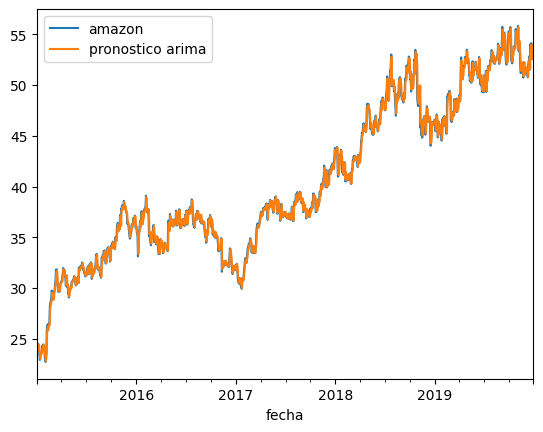

In [52]:
df_amazon['amazon'].plot(label='amazon')
df_amazon['pronostico'].plot(label='pronostico arima')
plt.legend()
plt.show()

In [53]:
## Predecir futuro
results.predict(start= '2019-12-28', end='2020-01-28')

2019-12-30    52.847340
2019-12-31    52.833947
2020-01-01    52.823902
2020-01-02    52.816367
2020-01-03    52.810716
2020-01-06    52.806477
2020-01-07    52.803298
2020-01-08    52.800914
2020-01-09    52.799126
2020-01-10    52.797784
2020-01-13    52.796778
2020-01-14    52.796023
2020-01-15    52.795457
2020-01-16    52.795033
2020-01-17    52.794715
2020-01-20    52.794476
2020-01-21    52.794297
2020-01-22    52.794162
2020-01-23    52.794062
2020-01-24    52.793986
2020-01-27    52.793929
2020-01-28    52.793887
Freq: B, Name: predicted_mean, dtype: float64

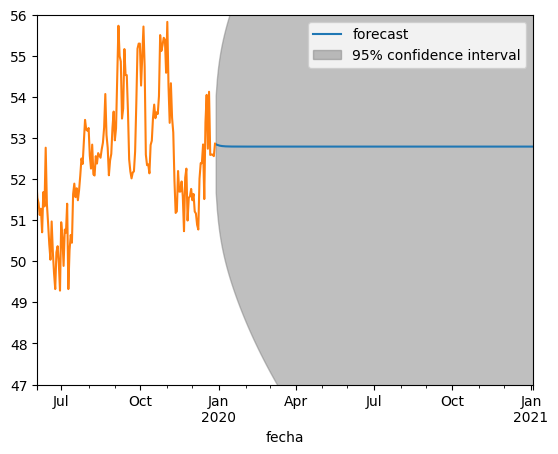

In [59]:
plot_predict(results, start= '2019-12-28', end='2021-02-05')
df_amazon['amazon'].plot()
plt.ylim(47,56)
plt.xlim('2019-06-01', '2021-01-05')
plt.show()

Los modelos ARIMA son modelo de pronostico a corto plazo. Conforme mas se pronostica a futuro el intervalo de confianza se vuelve más grande, es decir, entre más pronostique a futuro el modelo se va a equivocar más.\
También a partir de cierto periodo el modelo ARIMA pronostica una constante, esto es porque el modelo no puede ver ese futuro.\
Por eso es que decimos que los modelos arima son modelos para prónosticos de corto plazo. En general si tenemos un ARIMA(2,1,1) se considera que el modelo puede hacer un buen pronostico de dos periodos, si tenemos un ARIMA(3,0,1)
 se considera que se hace un buen pronostico de 3 periodos, si tenemos un ARIMA(1,1,3) se considera que se hace un buen pronóstico de 3 periodos.

In [62]:
results.predict(start='2019-12-28', end='2019-12-30')

2019-12-30    52.84734
Freq: B, dtype: float64

In [63]:
ultima_obs

fecha     2019-12-30 00:00:00
amazon              51.478008
Name: 1254, dtype: object